In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = 'D:/data/cifar-10/'

In [3]:
def read_csv_labels(fname):#读取文件
    with open(fname,'r')as f:
        lines=f.readlines()[1:]#去除第一行
    tokens=(l.rstrip().split(',')for l in lines)#获得名称列表
    return dict(((name,label)for name,label in tokens))
labels=read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
print(labels)

{'1': 'frog', '2': 'truck', '3': 'truck', '4': 'deer', '5': 'automobile', '6': 'automobile', '7': 'bird', '8': 'horse', '9': 'ship', '10': 'cat', '11': 'deer', '12': 'horse', '13': 'horse', '14': 'bird', '15': 'truck', '16': 'truck', '17': 'truck', '18': 'cat', '19': 'bird', '20': 'frog', '21': 'deer', '22': 'cat', '23': 'frog', '24': 'frog', '25': 'bird', '26': 'frog', '27': 'cat', '28': 'dog', '29': 'deer', '30': 'airplane', '31': 'airplane', '32': 'truck', '33': 'automobile', '34': 'cat', '35': 'deer', '36': 'airplane', '37': 'cat', '38': 'horse', '39': 'cat', '40': 'cat', '41': 'dog', '42': 'bird', '43': 'bird', '44': 'horse', '45': 'automobile', '46': 'automobile', '47': 'automobile', '48': 'bird', '49': 'bird', '50': 'airplane', '51': 'truck', '52': 'dog', '53': 'horse', '54': 'truck', '55': 'bird', '56': 'bird', '57': 'dog', '58': 'bird', '59': 'deer', '60': 'cat', '61': 'automobile', '62': 'automobile', '63': 'ship', '64': 'bird', '65': 'automobile', '66': 'automobile', '67': '

In [46]:
def copy_file(filename,target_dir):#将文件拷贝到指定地址
    os.makedirs(target_dir,exist_ok=True)
    shutil.copy(filename,target_dir)

def reorg_train_valid(data_dir,labels,valid_ratio):#整理train和valid文件
    n=collections.Counter(labels.values()).most_common()[-1][1]#获取出现最多的标签数量
    n_valid_per_label=max(1,math.floor(n*valid_ratio))#每个标签对应图片需要多少验证集
    label_count={}#记录当前标签拥有多少验证集
    for train_file in os.listdir(os.path.join(data_dir,'train')):
        label=labels[train_file.split('.')[0]]#图片标签列表
        fname=os.path.join(data_dir,'train',train_file)
        copy_file(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))#全部拷贝到train_valid文件
        if label not in label_count or label_count[label]<n_valid_per_label:
            copy_file(fname,os.path.join(data_dir,'train_valid_test','valid',label))#少于一定数量时，放入valid文件
            label_count[label]=label_count.get(label,0)+1
        else:
            copy_file(fname,os.path.join(data_dir,'train_valid_test','train',label))#超出数量时，放入train文件
    return n_valid_per_label

In [47]:
def reorg_test(data_dir):#整理test文件
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copy_file(os.path.join(data_dir,'test',test_file),os.path.join(data_dir,'train_valid_test','test','unknown'))

In [48]:
def reorg_cifar10_data(data_dir,valid_ratio):#整理数据集文件
    labels=read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
    reorg_train_valid(data_dir,labels,valid_ratio)
    reorg_test(data_dir)

In [49]:
#超参数，批量大小和验证集比率
batch_size=32
valid_ratio=0.1
reorg_cifar10_data(data_dir,valid_ratio)

In [50]:
transform_train=torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])#微调训练图片函数

transform_test=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])#微调测试图片函数


In [51]:
train_ds,train_valid_ds=[torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_valid_test',folder),
    transform=transform_train)for folder in ['train','train_valid']]
#微调训练数据数据，形成数据集
valid_ds,test_ds=[torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_valid_test',folder),
    transform=transform_test)for folder in ['valid','test']]
#微调验证和测试数据，形成数据集

In [52]:
train_iter,train_valid_iter=[torch.utils.data.DataLoader(
    dataset,batch_size,shuffle=True,drop_last=True)for dataset in(train_ds,train_valid_ds)]#获得训练集
valid_iter=torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)#获得验证集
test_iter=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)#获得测试集

In [ ]:
def get_net():#获得神经网络模型，使用resnet
    num_classes=10
    net=d2l.resnet18(num_classes,3)
    return net
loss=nn.CrossEntropyLoss(reduction='none')#交叉熵损失函数

In [ ]:
def train(net,train_iter,test_iter,num_epochs,lr,wd,devices,lr_period,lr_decay):#训练函数
    trainer=torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=wd)#SGD优化器
    scheduler=torch.optim.lr_scheduler.StepLR(trainer,lr_period,lr_decay)#变学习率优化器
    num_batches,timer=len(train_iter),d2l.Timer()#批次数量和训练时间计时器
    legend=['train_loss','train_acc']#可视化图标签
    if valid_iter is not None:
        legend.append('valid_acc')
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=legend)
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])#在gpu上训练
    for epoch in range(num_epochs):#开始训练
        net.train()
        #以下均为可视化
        metric=d2l.Accumulator(3)
        for i,(features,labels)in enumerate(train_iter):
            timer.start()
            l,acc=d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

IndexError: list index out of range

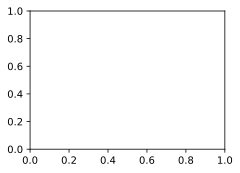

In [ ]:
#超参数
# 设备，训练批次，学习率，权重衰减比率
devices,num_epochs,lr,wd=d2l.try_all_gpus(),20,2e-4,5e-4
#学习率下降周期，学习率下降比率，模型
lr_period,lr_decay,net=4,0.9,get_net()

train(net,train_iter,valid_iter,num_epochs,lr,wd,devices,lr_period,lr_decay)